# VAE on the real BACMMAN dataset

In [1]:
# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/BACMMAN_DISTNET/')

!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-jk_1k94y
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-jk_1k94y
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=23766b69a857164d7fb2a96145333184b5dd763b53204aeb31e2469de125d316
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbyqp7ta/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
  Cloning https://github.com/jeanollion/distnet.git to /tmp/pip-req-build-p2z2iz3a
  Running command git clone -q https://github.com/jeanollion/distnet.git /tmp/pip-req-build-p2z2iz3a
  Created wheel for distnet: filename=distnet-0.0.1-cp36-none-any.whl size=51344 sha256=e8d2ec24614458ac50310380154799a5f57eb803a57921198b658b8f6d87f243

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


/home/train_val_eval.h5
Mon Aug  3 13:35:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

## Load datasets

In [2]:
# concatenate evaluation sets (norm only and anormal only) into a single h5
# file --> more convenient to load them into a single iterator after

from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

eval_set_path = "/home/eval_set.h5"

# evaluation set, nominal and anormal classes ()
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )

x_test_anorm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )


def get_images(iterator):
    images = []
    for i in range(len(iterator)):
        bx, by = iterator[i]
        for im in bx:
            images.append(im)
    return np.array(images)

# get images
nominal_images = get_images(x_test_norm)
n_nominal = nominal_images.shape[0]
print(f"{n_nominal} nominal images")
anormal_images = get_images(x_test_anorm)
n_anormal = anormal_images.shape[0]
print(f"{n_anormal} anormal images")

with h5py.File(eval_set_path, 'w') as out_file:
    out_file.create_dataset("eval/0/raw", data=get_images(x_test_norm))
    out_file.create_dataset("eval/0/labels", data=np.zeros(n_nominal))
    out_file.create_dataset("eval/1/raw", data=get_images(x_test_anorm))
    out_file.create_dataset("eval/1/labels", data=np.array([1 for i in range(n_anormal)]))

851 nominal images
1011 anormal images


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling
from dataset_iterator.helpers import get_min_and_max

corruption_function = lambda im: im + np.random.uniform(0, 0, im.shape) 

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_train = ImageDataGenerator(
                                horizontal_flip=True,
                                # vertical_flip=True,
                                # height_shift_range=0.2,
                                # channel_shift_range=0.2,
                                fill_mode="nearest",)

def corruption_mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only


def mm_scaling(batch_by_channel):
    minpix, maxpix = np.amin(batch_by_channel[0]), np.amax(batch_by_channel[0])
    batch_by_channel[0] = (batch_by_channel[0] - minpix) / (maxpix - minpix)

In [4]:
# train set, interest class only ([augmentation + corruption, augmentation without corruption])
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_train, None],
                                channels_postprocessing_function=corruption_mm_scaling,
                                batch_size=100
                                )

# validation set, interest class only ([augmentation without corruption])
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                channels_postprocessing_function=mm_scaling,
                                batch_size=100
                                )

# evaluation set, nominal and anormal classes ()
x_test = MultiChannelIterator(dataset=eval_set_path, 
                                channel_keywords=["/raw", "/labels"],
                                group_keyword = ["eval/{}/".format(lab) for lab in range(2)],
                                input_channels=[0],
                                output_channels=[0, 1],
                                channels_postprocessing_function=mm_scaling, 
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 100 of size 100


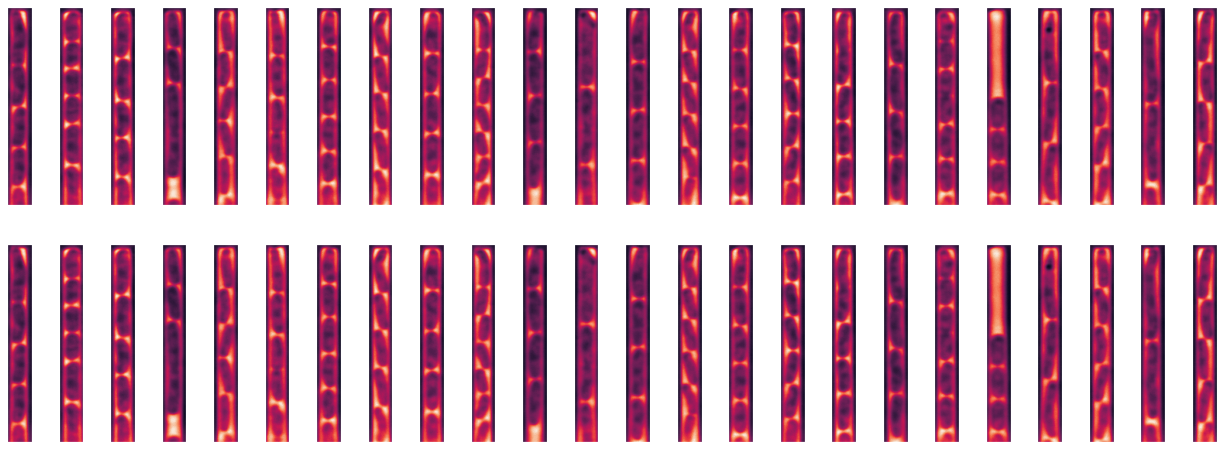

In [5]:
def plot_small_batches(n_batches=6, n=4, labx=None, laby=None):
    fig, axes = plt.subplots(2, n_batches * n, figsize=(22, 8), sharex="all", sharey="all")
    for batch in range(n_batches):
        bx, by = x_train[batch]
        for i in range(n):
            axes[0][i + batch * n].imshow(bx[i].squeeze(-1))
            axes[1][i + batch * n].imshow(by[i].squeeze(-1))
            axes[0][i + batch * n].get_xaxis().set_visible(False)
            axes[1][i + batch * n].get_yaxis().set_visible(False)
            axes[0][i + batch * n].get_xaxis().set_ticks([])
            axes[1][i + batch * n].get_yaxis().set_ticks([])

plot_small_batches()

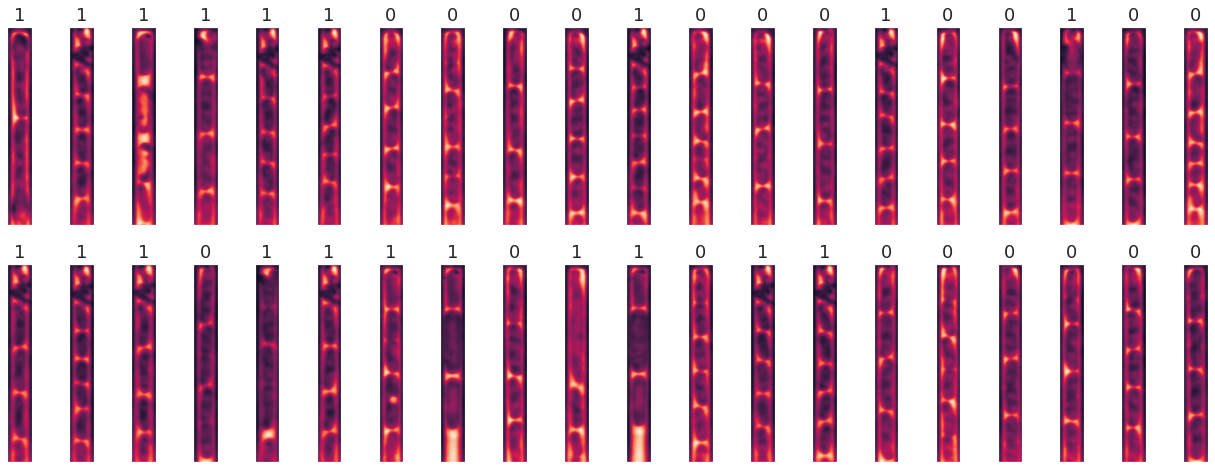

In [6]:
# check if the labels in x_test correspond to the images

def plot_images(bx, labs, n_ims=20):
    fig, axes = plt.subplots(2, (n_ims + 1) // 2, figsize=(22, 8), sharex="all", sharey="all")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(bx[i].squeeze(-1))
        ax.set_title(int(labs[i]))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

bx, (by, labsy) = x_test[0]
plot_images(by, labsy, n_ims=40)

## Build model

In [7]:
from uad.models.architecture import get_unet_vae, get_ruff_vae, conv2d_block
from tensorflow.keras import layers, Model, Input
from uad.models.variational_autoencoder import Sampling
from uad.models.self_attention import SelfAttention

n_filters = 64
n_contractions = 4
input_dims = (256, 32, 1)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout, spatial_dropout = False, 0.2, 0.2
activation_function = "leaky_relu"
k_size = (3, 1)
self_attention = True
final_activation = "tanh"






encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions,
                                input_dims=input_dims, k_size=k_size, batchnorm=batchnorm,
                                dropout=dropout, spatial_dropout=spatial_dropout,
                                activation_function=activation_function, latent_depth=latent_depth,
                                self_attention=self_attention)

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 32, 64)  256         encoder_inputs[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 32, 64)  12352       activation[0][0]                 
____________________________________________________________________________________________

In [8]:
from uad.models.variational_autoencoder import VAE

vae = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse", BETA=1)

# import os
# os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
# vae.load_weights("vae_UNet_BACT_weights")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,  # step = epochs or batch?
    decay_rate=0.9)  # for 100 epochs, final lr between 9.98e-5 and 9e-5

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

In [9]:
epochs = 100
batch_size = 4

checkpoint_path = "/content/drive/My Drive/BACMMAN_DISTNET/models/vae_unet_BACT_weights"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=1000,
                                                 save_best_only=False)

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train, validation_data=x_val, epochs=epochs, 
                  callbacks=[tensorboard_callback, cp_callback])

Epoch 1/100
100/100 [==============================] - 37s 374ms/step - loss: 1880848.8403 - reconstruction_loss: 1880793.7262 - kl_loss: 55.0727 - val_loss: 22709.3750 - val_reconstruction_loss: 22699.4453 - val_kl_loss: 9.9300
Epoch 2/100
100/100 [==============================] - 38s 376ms/step - loss: 7689.0560 - reconstruction_loss: 7682.6391 - kl_loss: 6.4168 - val_loss: 6252.9204 - val_reconstruction_loss: 6245.9194 - val_kl_loss: 7.0010
Epoch 3/100
100/100 [==============================] - 38s 381ms/step - loss: 4724.1141 - reconstruction_loss: 4717.5368 - kl_loss: 6.5773 - val_loss: 3960.3672 - val_reconstruction_loss: 3954.2766 - val_kl_loss: 6.0906
Epoch 4/100
100/100 [==============================] - 38s 383ms/step - loss: 3327.5021 - reconstruction_loss: 3320.8672 - kl_loss: 6.6349 - val_loss: 3079.9009 - val_reconstruction_loss: 3071.7051 - val_kl_loss: 8.1959
Epoch 5/100
100/100 [==============================] - 39s 386ms/step - loss: 2564.6785 - reconstruction_loss: 

Seems that during training, we come to a local optimum with reconstrution loss around 115 and KL around 3. This local optimum is achieved when the model only predicts red images (0 everywhere) on evaluation set. Issue with the loss? Use another loss?

Other observation: during training, the validation loss is much lower (around 40) than the training loss, even without regularisation... Explanation? Is it linked with the first issue?

In [10]:
%load_ext tensorboard
%tensorboard --logdir logs

Output hidden; open in https://colab.research.google.com to view.

In [18]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(vae, "vae_UNet_BACT_sigmoid")

INFO:tensorflow:Assets written to: vae_UNet_BACT_sigmoid/assets


In [12]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
vae = tf.keras.models.load_model("vae_UNet_BACT")

In [19]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
vae.save_weights("vae_UNet_BACT_weights_sigmoid", overwrite=True)

## Plot images and reconstructions

(64, 256, 32)
(array([ 0, 16]),)


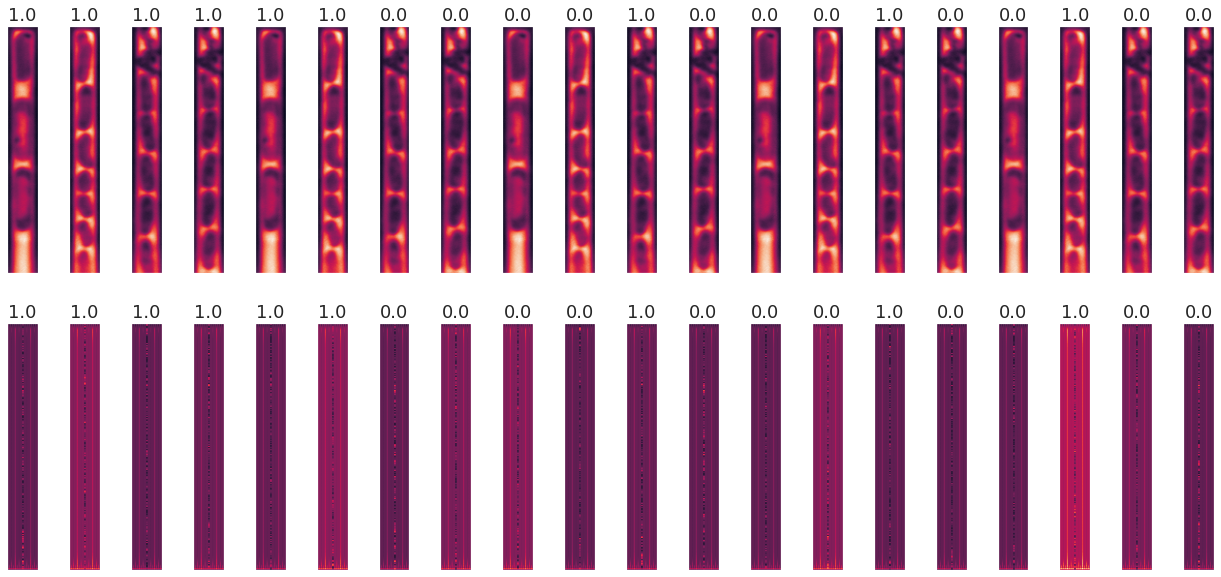

In [81]:
def plot_images_reconstructions(model, iterator, n_images=15, batch=10):

    fig, axes = plt.subplots(2, n_images, figsize=(22, 10), sharex="all", sharey="all")

    bx, (by, lab) = iterator[batch]
    pred = model.predict(by)
    predictions = np.array(pred).squeeze()

    print(predictions.shape)
    
    for i in range(n_images):
        axes[0][i].imshow(by[i % batch_size].squeeze(-1))
        axes[0][i].set_title(laby[i])
        axes[1][i].imshow(np.clip(predictions[i], 0, 1))
        axes[1][i].set_title(laby[i])
        axes[0][i].get_xaxis().set_visible(False)
        axes[1][i].get_yaxis().set_visible(False)
        axes[0][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])

plot_images_reconstructions(vae, x_test, n_images=20, batch=4)    

Really weird... The model predicts almost everywhere the same values, except in the center column (index 16). Even weirder, the model achieves a 0.83 AUC score just with the information contained in this "barcode" column (see below).

0
(512, 2)
1
(512, 2)
2
(512, 2)
3
(512, 2)
4
(512, 2)
5
(512, 2)
6
(512, 2)
7
(512, 2)
8
(512, 2)
9
(512, 2)
10
(512, 2)
11
(512, 2)
12
(512, 2)
13
(512, 2)
14
(512, 2)
15
(512, 2)
16
(512, 2)
17
(512, 2)
18
(512, 2)
19
(512, 2)
20
(512, 2)
21
(512, 2)
22
(512, 2)
23
(512, 2)
24
(512, 2)
25
(512, 2)
26
(512, 2)
27
(512, 2)
28
(512, 2)
29
(512, 2)
30
(512, 2)
31
(512, 2)
32
(512, 2)
34
(512, 2)
35
(512, 2)
36
(512, 2)
37
(512, 2)
38
(512, 2)
39
(512, 2)
40
(512, 2)
41
(512, 2)
42
(512, 2)
43
(512, 2)
44
(512, 2)
45
(512, 2)
46
(512, 2)
47
(512, 2)
48
(512, 2)
49
(512, 2)
50
(512, 2)
51
(512, 2)
52
(512, 2)
53
(512, 2)
54
(512, 2)
55
(512, 2)
56
(512, 2)
57
(512, 2)
58
(512, 2)
59
(512, 2)
60
(512, 2)
61
(512, 2)
62
(512, 2)
63
(512, 2)


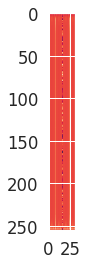

In [91]:
_, (by, laby) = x_test[19]
predictions = vae.predict(by)

ref_idx = 33

for i in range(len(predictions)):
    if i != ref_idx:
        print(i)
        print(np.argwhere(predictions[ref_idx].squeeze(-1) != predictions[i].squeeze(-1)).shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(predictions[57].squeeze(-1))

## Compute ROC

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1.]
[ 9.152742  12.068353  15.640791  10.662347  11.848514  12.212279
 11.018684  10.189248  10.536584  11.196248  13.235798  11.681206
  9.973526  10.416439  12.307872  10.9512205 11.651041   9.928907
 10.832556  12.223197  11.882804  12.498218  11.664286  10.98441
 12.644179  12.239501  10.516556  15.056796  10.516957  10.785512 ]


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f62bc120c18>)

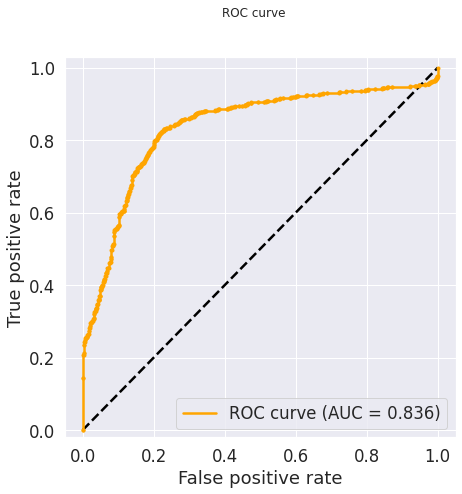

In [68]:
from uad.diagnostic.metrics import plot_ROC, is_binary, binarize_set
from sklearn.metrics import roc_curve

def score_samples_iterator(self, dataset_iterator):
    """
    Returns the anomaly scores for data (name of the method inspired from the sklearn
    interface) when data is given in an iterator
    :param dataset_iterator: image or batch of images
    :param decision_function: can be either "distance" to predict anomalies based on their distance to the model's center
    (in an SVDD manner) or "reconstruction" to predict anomalies based on the reconstruction error between the input
    image and the reconstruction (using MSE, in a VAE manner).
    Return: scores in the batch format
    """
    scores = []
    for i in range(len(dataset_iterator)):
        _, (ims, labs) = dataset_iterator[i]
        if (i + 1) % 50 == 0:
            print(f"making predictions on batch {i + 1}...")
        predictions = self.predict(ims)
        y_scores = np.sqrt(np.sum((predictions - ims) ** 2, axis=(1, 2, 3)))
        for elt in y_scores:
            scores.append(elt)
    return np.array(scores)


def compute_ROC_iterator(self, dataset_iterator, interest_digit=0):
    """
    :param dataset_iterator:
    :param decision_function:
    :param batch:
    :param interest_digit:
    :return:
    """
    labels = []
    for i in range(len(dataset_iterator)):
        _, (ims, y_true) = dataset_iterator[i]
        for elt in y_true:
            labels.append(elt)

    y_trues = np.array(labels).flatten()
    y_scores = score_samples_iterator(self, dataset_iterator).flatten()

    print(y_trues[:30])
    print(y_scores[:30])

    fpr, tpr, thresholds = roc_curve(y_trues, y_scores, pos_label=1)

    return fpr, tpr, thresholds


fpr, tpr, _ = compute_ROC_iterator(vae, x_test, interest_digit=0)
plot_ROC(fpr, tpr)

## Plot scores distribution

851 normal examples
1011 normal examples


(<Figure size 1080x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f62bc2c8550>,
       dtype=object))

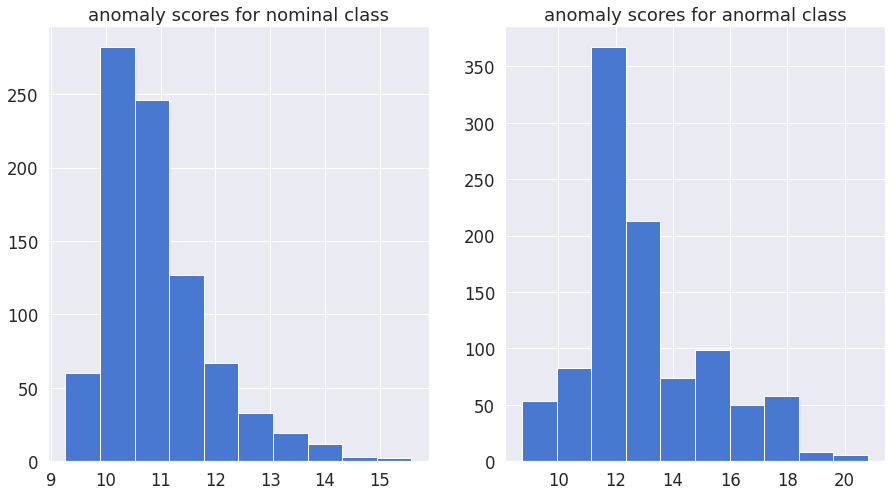

In [67]:
def plot_scores_distrib(self, dataset_iterator):
    """
    Plot the distribution of anomaly scores computed on dataset_iterator, for
    the normal class and for the anormal class
    :param dataset_iterator:
    :param interest_class:
    :return:
    """
    y_trues = []
    for i in range(len(dataset_iterator)):
        _, (ims, labs) = dataset_iterator[i]
        for lab in labs:
            y_trues.append(lab)
    y_trues = np.array(y_trues)
    sc = score_samples_iterator(self, dataset_iterator).flatten()

    scores_nominal = sc[y_trues == 0.]
    scores_anormal = sc[y_trues == 1.]

    print(f"{scores_nominal.shape[0]} normal examples")
    print(f"{scores_anormal.shape[0]} normal examples")

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].hist(scores_nominal)
    axes[0].set_title("anomaly scores for nominal class")
    axes[1].hist(scores_anormal)
    axes[1].set_title("anomaly scores for anormal class")

    return fig, axes


plot_scores_distrib(vae, x_test)

We effectively have different anomaly score distributions for both classes!

## Plot t-SNE of the latent space

t-SNE inputs shape: (1862, 32768)
t-SNE output shape: (1862, 2)
2


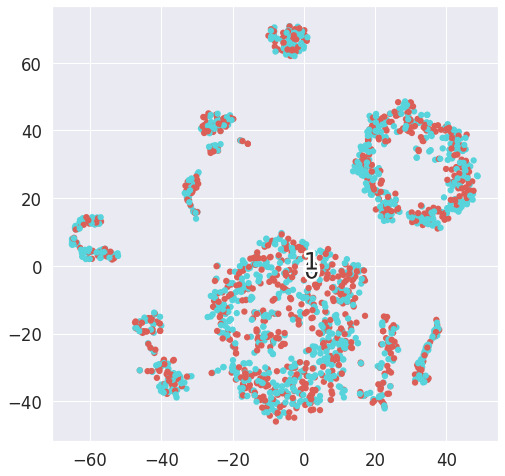

In [98]:
from uad.diagnostic.visualisation import plot_tSNE

z_means, _, _ = vae.encoder.predict(x_test)

labels = []
for k in range(len(x_test)):
    bx, (by, labs) = x_test[k]
    for lab in labs:
        labels.append(lab)
    
labels = np.array(labels).flatten()

fig, axes, scs, txt = plot_tSNE(z_means, labels, axis=0, plot_center=np.array([False]))

Classes are not separated in the latent space...